In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html

In [2]:
from __future__ import division
import tensorflow as tf
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from IPython.display import Image
from IPython.core.display import HTML
from mylibs.tf_helper import getDefaultGPUconfig
from data_providers.binary_shifter_varlen_data_provider import \
    BinaryShifterVarLenDataProvider
from data_providers.price_history_varlen_data_provider import PriceHistoryVarLenDataProvider
from models.price_history_rnn_varlen import PriceHistoryRnnVarlen
from sklearn.metrics import r2_score
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from os.path import isfile

In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
%matplotlib inline

In [4]:
from common import get_or_run_nn

### Step 0 - hyperparams

In [5]:
num_epochs = 10
series_max_len = 60
num_features = 1  #just one here, the function we are predicting is one-dimensional
state_size = 400
target_len = 30
batch_size = 58

In [6]:
# num_batches = series_max_len // batch_size
# print series_max_len / batch_size
# num_batches

### Step 1 - collect data (and/or generate them)

In [7]:
csv_in = '../price_history_02a_fixed_width.csv'
npz_path = '../price_history_02_dp_60to30_from_fixed_len.npz'

In [8]:
# XX, YY, sequence_lens, seq_mask = PriceHistoryVarLenDataProvider.createAndSaveDataset(
#     csv_in=csv_in,
#     npz_out=npz_path,
#     input_seq_len=60, target_seq_len=30)
# XX.shape, YY.shape, sequence_lens.shape, seq_mask.shape

In [9]:
dp = PriceHistoryVarLenDataProvider(filteringSeqLens = lambda xx : xx >= target_len,
                                    npz_path=npz_path)
dp.inputs.shape, dp.targets.shape, dp.sequence_lengths.shape, dp.sequence_masks.shape

((14036, 60, 1), (14036, 30), (14036,), (14036, 60))

### Step 2 - Build model

In [10]:
model = PriceHistoryRnnVarlen(rng=random_state, dtype=dtype, config=config)

In [11]:
graph = model.getGraph(batch_size=batch_size, state_size=state_size,
                       target_len=target_len, series_max_len=series_max_len)

learning rate: 0.001000
rnn_outputs:
Tensor("rnn_layer/rnn/transpose:0", shape=(58, 60, 400), dtype=float32)

Tensor("gathering/GatherNd:0", shape=(58, 30, 400), dtype=float32)

Tensor("flattening:0", shape=(1740, 400), dtype=float32)
Tensor("readout_layer/add:0", shape=(1740, 1), dtype=float32)

Tensor("predictions/Reshape:0", shape=(58, 30), dtype=float32)

Tensor("error/Select:0", shape=(58, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)



In [12]:
show_graph(graph)

### Step 3 training the network

In [30]:
num_epochs = 20
num_epochs, state_size, batch_size

(20, 400, 58)

In [31]:
def execute_experiment():
    dyn_stats, preds_dict = model.run(epochs=num_epochs,
                                      state_size=state_size,
                                      series_max_len=series_max_len,
                                      target_len=target_len,
                                      npz_path=npz_path,
                                      batch_size=batch_size)
    return dyn_stats, preds_dict

In [32]:
dyn_stats, preds_dict = get_or_run_nn(execute_experiment,
                                      filename='000_simple_rnn_with_outliers_60to30_20epochs')

epochs: 20
End Epoch 01 (18.787 secs): err(train) = 13.3048
End Epoch 02 (19.395 secs): err(train) = 12.7273
End Epoch 03 (19.378 secs): err(train) = 12.6015
End Epoch 04 (19.650 secs): err(train) = 12.4914
End Epoch 05 (19.580 secs): err(train) = 12.4303
End Epoch 06 (19.020 secs): err(train) = 12.8396
End Epoch 07 (18.893 secs): err(train) = 12.7759
End Epoch 08 (18.916 secs): err(train) = 12.5943
End Epoch 09 (18.877 secs): err(train) = 12.6341
End Epoch 10 (18.932 secs): err(train) = 12.5762
End Epoch 11 (19.082 secs): err(train) = 12.4776
End Epoch 12 (18.914 secs): err(train) = 12.5591
End Epoch 13 (18.914 secs): err(train) = 12.6490
End Epoch 14 (18.875 secs): err(train) = 12.5036
End Epoch 15 (18.956 secs): err(train) = 12.4433
End Epoch 16 (18.974 secs): err(train) = 12.4452
End Epoch 17 (19.126 secs): err(train) = 12.4377
End Epoch 18 (19.043 secs): err(train) = 12.4243
End Epoch 19 (18.907 secs): err(train) = 12.5163
End Epoch 20 (19.032 secs): err(train) = 12.6949



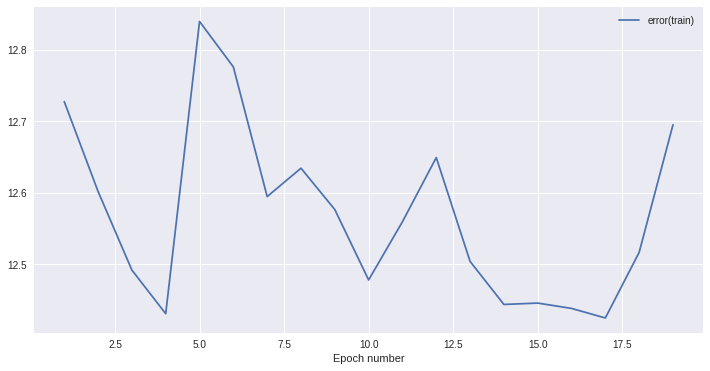

In [33]:
dyn_stats.plotStats()
plt.show()

In [34]:
dp.inputs[0].shape

(60, 1)

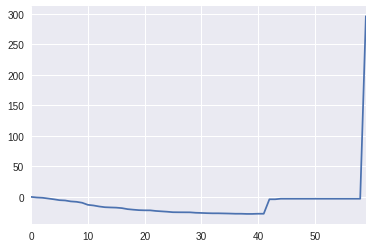

In [35]:
sns.tsplot(data=dp.inputs[2629].flatten())

In [36]:
ind = 2629 #14036 - 1

In [38]:
reals = dp.targets[ind]
preds = preds_dict[ind]

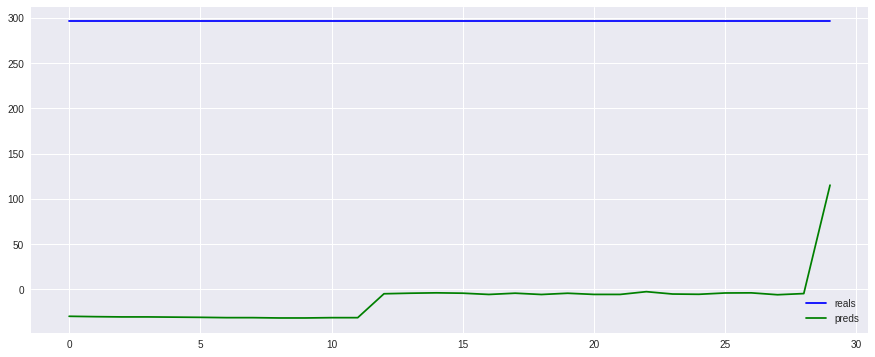

In [39]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [40]:
r2_score(y_true=reals, y_pred=preds)

-2.9477909771408917e+31

In [42]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [43]:
np.argmin(r2_scores)

2629

In [45]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 30 s, sys: 52 ms, total: 30 s
Wall time: 29.9 s


In [46]:
np.mean(dtw_scores)

353.48005936485049